# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Task to be performed:
1. In this, We need to work with Only BOW and TFIDF.
2. We need to Give proper reasoning for choosing the particular versions of Naive Bayes
3. Choose different metric other than accuracy for choosing the best hyperparameter,
which is apt for imbalanced datasets and accuracy sometimes gives us false conclusions
about the model performance sometimes.
4. Do hyperparameter tuning or some feature engineering and make your model better by
reducing the false positives (Ex: adding the length of the reviews, getting some features
from the summary column)
5. We need to print the important features for each class, use model attributes to get the
best features.
6. Avoid submitting the models which are more biased towards positive points. Try to
improve if everything or most of the points are predicting as positive.

In [62]:
import numpy 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re 
import sqlite3


In [63]:
con = sqlite3.connect("./amazon-fine-food-reviews/database.sqlite")
data = pd.read_sql_query('''
SELECT *
FROM REVIEWS
WHERE SCORE != 3''', con)
data.shape

(525814, 10)

# Data Cleaning

In [64]:
data = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]
data.shape

(525812, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [65]:
data['Score'] = data["Score"].apply(lambda x: "positive" if x > 3 else "negative")
sorted_data = data.sort_values('ProductId',axis = 0, inplace = False, kind = 'quicksort',ascending = True)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...


In [66]:
filtered_data = sorted_data.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = False)
filtered_data.shape

(328770, 10)

In [67]:
filtered_data['Score'].value_counts()

positive    275650
negative     53120
Name: Score, dtype: int64

In [68]:
final = filtered_data.copy()

In [69]:
import nltk

In [70]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\manish
[nltk_data]     dogra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
stop = set(stopwords.words("english"))


In [72]:
st = PorterStemmer()
st.stem('burned')

'burn'

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [73]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr,' ',sent)
    return cleaned
def cleanpunc(sent):
    clean = re.sub(r'[?|!|$|#|\'|"|:]',r'',sent)
    clean = re.sub(r'[,|(|)|.|\|/]',r' ',clean)
    return clean

In [74]:
i=0
all_positive_reviews =[]
all_negative_reviews = []
final_string = []
stem_data = " "
for p in final['Text'].values:
    filtered_sens = []#filtered word
    p = cleanhtml(p)
    for w in p.split():
       # print(w)
        punc = cleanpunc(w)
        for s in punc.split():
            #print(w)
            if (s.isalpha()) & (len(s)>2):
                if s.lower() not in stop:
                    stem_data = (st.stem(s.lower())).encode('utf8')
                    #can we use lemmatizer and stemming altogether??
                    filtered_sens.append(stem_data)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(stem_data)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(stem_data)
                else:
                    continue
            else:
                continue
    #print(filtered_sens)
    str1 = b" ".join(filtered_sens)
    #print(str1)
    final_string.append(str1)
    i+=1

In [75]:
final['CleanedText'] = final_string
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",b'charm rhyme book describ circumst eat dont c...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",b'daughter love realli rosi book introduc real...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,b'summari young boy describ use chicken soup r...


In [76]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [77]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = X[:100000]
y = final['Score'].values
y = y[:100000]

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y)

# Naive bayes on Bow

In [79]:
count_vect = CountVectorizer(binary =True) #in scikit-learn
bow_train = count_vect.fit_transform(X_train)
bow_test = count_vect.transform(X_test)
#count_vect.get_feature_names()

In [80]:
import numpy as np

In [81]:
alp = [10**i for i in range(-3,4)]

In [82]:
cross_score = []
for alphas in alp:
    clf = BernoulliNB(alpha = alphas)
    cross_val = cross_val_score(clf,bow_train,y_train,cv=10,scoring = 'accuracy',n_jobs = -1)
    cross_score.append(cross_val.mean())

In [83]:
MSE = [1-x for x in cross_score]
optimal_alpha = alp[MSE.index(min(MSE))]

In [84]:
optimal_clf = BernoulliNB(alpha = optimal_alpha)
optimal_clf.fit(bow_train,y_train)
pred  = optimal_clf.predict(bow_test)


# Accuracy

In [85]:
acc = accuracy_score(y_test,pred)*100
print("The accuracy for optimal alpha = {0} is {1}".format(optimal_alpha,acc))

The accuracy for optimal alpha = 0.001 is 89.995


In [86]:
from sklearn.metrics import classification_report
#target_names = ['class 0', 'class 1']
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.62      0.53      0.58      2541
   positive       0.93      0.95      0.94     17459

avg / total       0.89      0.90      0.90     20000



# Recall , Precison and auc_score

In [87]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
0.953090096798
0.534828807556


PRECISION SCORE
0.933677477275
0.623966942149


# ROC Curve

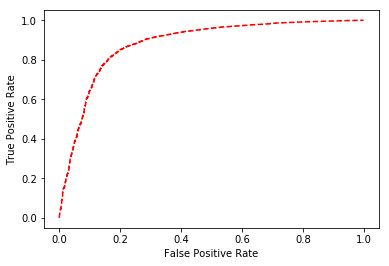

In [88]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred =optimal_clf.predict_proba(bow_test)[:,1]
#print(y_pred[:,1])

fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [89]:
print(roc_auc_score(y_true,y_pred))

0.881352542626


# Confusion Matrix

[[ 1359  1182]
 [  819 16640]]


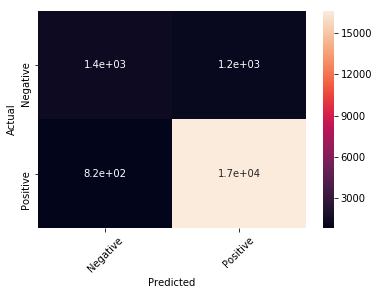

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Important words(features)

In [91]:
neg_class = optimal_clf.feature_log_prob_[0,:].argsort()
pos_class = optimal_clf.feature_log_prob_[1,:].argsort()
print(np.take(count_vect.get_feature_names(), neg_class[::-1][:10]))
print(np.take(count_vect.get_feature_names(), pos_class[::-1][:10]))


['tast' 'like' 'product' 'one' 'would' 'tri' 'good' 'flavor' 'buy' 'get']
['tast' 'like' 'great' 'good' 'love' 'flavor' 'one' 'use' 'tri' 'product']


# Multinomial NB on BOW

In [92]:
from sklearn.naive_bayes import MultinomialNB
alp = [10**i for i in range(-3,4)]
cross_score = []
for alphas in alp:
    clf = MultinomialNB(alpha = alphas)
    cross_val = cross_val_score(clf,bow_train,y_train,cv=10,scoring = 'accuracy',n_jobs = -1)
    cross_score.append(cross_val.mean())

In [93]:
MSE = [1-x for x in cross_score]
optimal_alpha = alp[MSE.index(min(MSE))]
optimal_clf = MultinomialNB(alpha = optimal_alpha)
optimal_clf.fit(bow_train,y_train)
pred  = optimal_clf.predict(bow_test)

# Accuracy

In [94]:
acc = accuracy_score(y_test,pred)*100
print("The accuracy for optimal alpha = {0} is {1}".format(optimal_alpha,acc))

The accuracy for optimal alpha = 1 is 91.64999999999999


In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.73      0.55      0.63      2541
   positive       0.94      0.97      0.95     17459

avg / total       0.91      0.92      0.91     20000



# Recall , Precison and auc_score

In [96]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
0.969986826279
0.548996458087


PRECISION SCORE
0.936618549859
0.726941115164


# ROC Curve

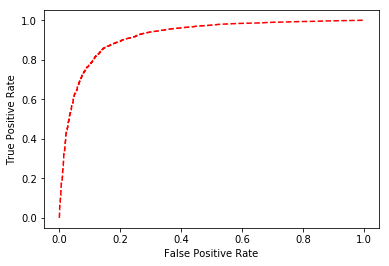

In [97]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred =optimal_clf.predict_proba(bow_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [98]:
print(roc_auc_score(y_true,y_pred))

0.919729551795


# Confusion Matrix

[[ 1395  1146]
 [  524 16935]]


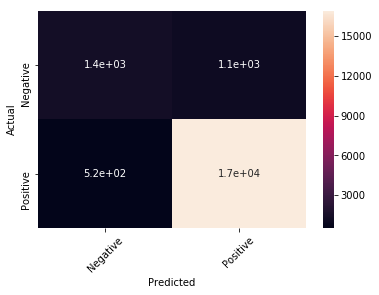

In [99]:
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Important words(features)

In [100]:
neg_class = optimal_clf.feature_log_prob_[0,:].argsort()
pos_class = optimal_clf.feature_log_prob_[1,:].argsort()
print(np.take(count_vect.get_feature_names(), neg_class[::-1][:10]))
print(np.take(count_vect.get_feature_names(), pos_class[::-1][:10]))


['tast' 'like' 'product' 'one' 'would' 'tri' 'good' 'flavor' 'buy' 'get']
['tast' 'like' 'great' 'good' 'love' 'flavor' 'one' 'use' 'tri' 'product']


# Naive Bayes on Tf-idf

In [101]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
tfidf_train = tfidf_vect.fit_transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)

In [102]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)
X_tr= sc.fit_transform(tfidf_train)
X_te = sc.transform(tfidf_test)

In [103]:
alp_1 = [10**i for i in range(-3,4)]

In [104]:
cross_score_1 = []
for alphas in alp_1:
    clf_1 = BernoulliNB(alpha = alphas)
    cross_val_1 = cross_val_score(clf_1,X_tr,y_train,cv=10,scoring = 'accuracy',n_jobs = -1)
    cross_score_1.append(cross_val_1.mean())

In [105]:
MSE_1 = [1-x for x in cross_score_1]
opt_alpha = alp_1[MSE_1.index(min(MSE_1))]

In [106]:
opt_clf = BernoulliNB(alpha = opt_alpha)
opt_clf.fit(X_tr,y_train)
pred_1  = opt_clf.predict(X_te)

# Accuracy

In [107]:
acc_1 = accuracy_score(y_test,pred_1)*100
print("The accuracy for optimal alpha = {0} is {1}".format(opt_alpha,acc_1))

The accuracy for optimal alpha = 0.001 is 90.0


In [109]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_1))

             precision    recall  f1-score   support

   negative       0.86      0.25      0.39      2541
   positive       0.90      0.99      0.95     17459

avg / total       0.90      0.90      0.88     20000



# Recall , Precision and auc_score

In [110]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred_1,pos_label = 'positive'))
print(recall_score(y_test,pred_1,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred_1,pos_label = 'positive'))
print(precision_score(y_test,pred_1,pos_label = 'negative'))

RECALL SCORE
0.994043186895
0.253837072019


PRECISION SCORE
0.901511609787
0.861148197597


# ROC Curve

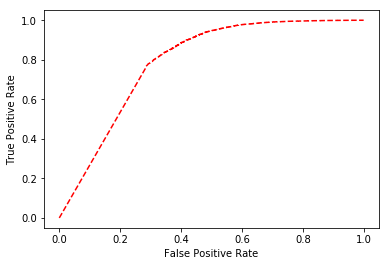

In [111]:
change = lambda x : 1 if x == 'positive' else 0
tfidf_true = np.array([change(x) for x in y_test])
tfidf_pred =opt_clf.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(tfidf_true, tfidf_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [112]:
print(roc_auc_score(tfidf_true,tfidf_pred))

0.789832981162


# confusion matrix

[[  645  1896]
 [  104 17355]]


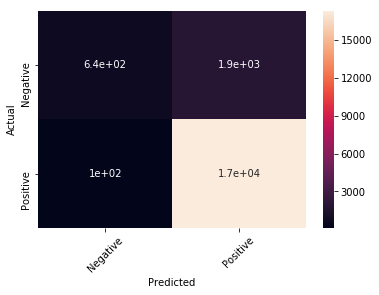

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred_1)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Important Words (features)

In [114]:
ne_class = opt_clf.feature_log_prob_[0,:].argsort()
po_class = opt_clf.feature_log_prob_[1,:].argsort()
print(np.take(tfidf_vect.get_feature_names(), ne_class[::-1][:10]))
print(np.take(tfidf_vect.get_feature_names(), po_class[::-1][:10]))


['tast' 'like' 'product' 'one' 'would' 'tri' 'good' 'flavor' 'buy' 'get']
['tast' 'like' 'great' 'good' 'love' 'flavor' 'one' 'use' 'tri' 'product']


# Multinomial NB on tfidf 

In [115]:
from sklearn.naive_bayes import MultinomialNB
alp = [10**i for i in range(-3,4)]
cross_score = []
for alphas in alp:
    clf = MultinomialNB(alpha = alphas)
    cross_val = cross_val_score(clf,X_tr,y_train,cv=10,scoring = 'accuracy',n_jobs = -1)
    cross_score.append(cross_val.mean())

In [116]:
MSE = [1-x for x in cross_score]
optimal_alpha = alp[MSE.index(min(MSE))]
optimal_clf = MultinomialNB(alpha = optimal_alpha)
optimal_clf.fit(X_tr,y_train)
pred  = optimal_clf.predict(X_te)

# Accuracy

In [117]:
acc = accuracy_score(y_test,pred)*100
print("The accuracy for optimal alpha = {0} is {1}".format(optimal_alpha,acc))

The accuracy for optimal alpha = 0.001 is 86.36


In [118]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.41      0.17      0.24      2541
   positive       0.89      0.96      0.93     17459

avg / total       0.83      0.86      0.84     20000



# Recall , Precision and auc_score

In [119]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
0.964201844321
0.172373081464


PRECISION SCORE
0.888947562972
0.412041392286


# ROC Curve

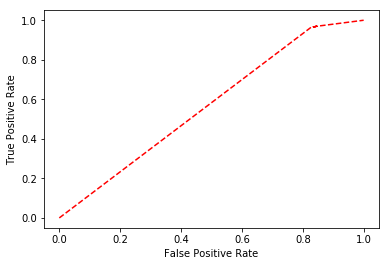

In [120]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred =optimal_clf.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [121]:
print(roc_auc_score(y_true,y_pred))

0.568656348728


# confusion matrix

[[  438  2103]
 [  625 16834]]


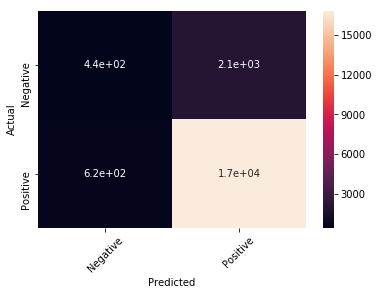

In [122]:
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Important Words (features)

In [124]:
neg_class = optimal_clf.feature_log_prob_[0,:].argsort()
pos_class = optimal_clf.feature_log_prob_[1,:].argsort()
print(np.take(tfidf_vect.get_feature_names(), neg_class[::-1][:10]))
print(np.take(tfidf_vect.get_feature_names(), pos_class[::-1][:10]))


['tast' 'like' 'disappoint' 'product' 'would' 'one' 'bad' 'money' 'tri'
 'dont']
['great' 'tast' 'love' 'like' 'good' 'flavor' 'use' 'one' 'tri' 'make']


<h1>Report</h1>
<h3>Bernoulii NB on BOW</h3>
* Optimal alpha = 0.001
* Accuracy = 89.995
* Precision = 0.936(positive), 0.623(negative)
* Recall = 0.953 ,0.534
* AUC = 0.881
* TN = 1359
* TP = 16640
<h3>Bernoulii NB on TF-IDF</h3>
* Optimal alpha = .001
* Accuracy = 90.0
* Precision = 0.901, 0.861
* Recall = 0.994, 0.253
* AUC = 0.789
* TN = 645
* TP = 17355
<h3>Multinomial NB on BOW</h3>
* Optimal alpha = 1
* Accuracy = 91.649
* Precision = 0.936 , 0.726
* Recall = 0.969 , 0.548
* AUC = 0.919
* TN = 1395
* TP = 16935
<h3>Multinomial NB on TF-IDF</h3>
* Optimal alpha = .001
* Accuracy = 86.36
* Precision = .888, 0.412
* Recall = .964, 0.172
* AUC = 0.568
* TN = 438
* TP = 16834